In [84]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as k
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
import sounddevice as sd
import pydub
import uuid
import json
import math
import os

Recording...
Recording done


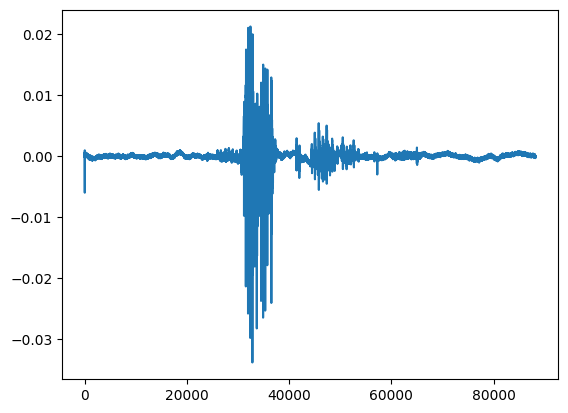

In [79]:
#sample a sound using your microphone and then visualize it
#f = 1/T => T=duration * fs
#fs = 44100Hz
fs = 44100
duration=2
print("Recording...")
val = sd.rec(frames = fs*duration, samplerate = fs, channels = 1)
print("Recording done")

plt.plot(val)

np.save('test.npy', val)
val = np.load('test.npy')

In [76]:
#create a file meta.txt in a subdirectory(sound) of the working directory, in that same subdirectory we will store our recording samples
#that we will use for the model training, validation and testing
data_path = ".\\sound\\"
meta_data_file = data_path + 'meta.txt'
print(meta_data_file)

.\sound\meta.txt


With the code below, I recorded 100 samples saying the word "forward", 100 samples saying the word "backwards" and 200 samples saying random words or just making background noise
I labeled the recordings with 3 kinds of samples, one for each category from above

In [80]:
#sample a given nr of sound(record_number)s, save it inthe meta.txt file and in the special format with the data : id, sample_rate, duration, file_name, and label as shown below
#{'id': '64549a8854c04e97959e7ad6c8a9e301', 'sampling_rate': 44100, 'duration': 2, 'file_name': 'gb_121_.npy', 'label': 'gb'}


record_number = 10
count = 0
fs = 44100
duration=2
data_path = ".\\sound\\live\\"
meta_data_file ='live.txt'
label = 'backwards'
meta_data = {}
f = open(data_path + meta_data_file, mode = 'a')
for i in range(record_number):
    print("Recording...")
    f_name = label + '_live_' +str(count)+'_'+'.npy'
    meta_data['id'] = uuid.uuid4().hex
    meta_data['sampling_rate']=fs
    meta_data['duration'] = duration
    meta_data['file_name'] = f_name
    meta_data['label'] = label
    val = sd.rec(frames = fs*duration, samplerate=fs, channels=1)
    sd.wait()
    np.save(data_path+f_name, val)
    meta_json_data=json.dumps(meta_data)
    f.write(meta_json_data+'\n')
    count+=1
    print("meta_info", meta_data)
f.close()
print("Recording Done")


Recording...
meta_info {'id': 'fc455614fbf74a9f86811eb172e8f0bd', 'sampling_rate': 44100, 'duration': 2, 'file_name': 'backwards_live_0_.npy', 'label': 'backwards'}
Recording...
meta_info {'id': 'f0b683ed54f34d65a4173187bbfe922d', 'sampling_rate': 44100, 'duration': 2, 'file_name': 'backwards_live_1_.npy', 'label': 'backwards'}
Recording...
meta_info {'id': '7a318119f88647058ce3fc5d69a72513', 'sampling_rate': 44100, 'duration': 2, 'file_name': 'backwards_live_2_.npy', 'label': 'backwards'}
Recording...
meta_info {'id': '636c497f9afe415687ae542520eb08d9', 'sampling_rate': 44100, 'duration': 2, 'file_name': 'backwards_live_3_.npy', 'label': 'backwards'}
Recording...
meta_info {'id': '227e3ca83a154d039b40f8b3b712524c', 'sampling_rate': 44100, 'duration': 2, 'file_name': 'backwards_live_4_.npy', 'label': 'backwards'}
Recording...
meta_info {'id': '8744353113ab467da3be54a825c22172', 'sampling_rate': 44100, 'duration': 2, 'file_name': 'backwards_live_5_.npy', 'label': 'backwards'}
Recording.

In [16]:
#loading  the file in arrays
data_path = ".\\sound\\"
meta_data_file = data_path + 'meta.txt'

def data2fftimg(data):
    _,_,_,img = plt.specgram(data.flatten(), NFFT=96, Fs=fs, scale_by_freq=False,noverlap=64) #this function takes a data array as input and 
    img2d = img.make_image(None)[0][...,0:3]                                                  # generates a spectogram image using the Fast Fourier Transform
    return img2d

def int2cat(int_label, nr_out=3):
    #[0,0,0]                          #this function takes an int as input and outputs an array
    arr = np.zeros([nr_out])          # 0 - [1 0 0]
    arr[int(int_label)]=1             #1 - [0 1 0]
    return arr                        #2 - [0 0 1]

def data_loader(file_name):
    f = open(file_name, mode = 'r')  #this function loads the file(meta.txt) in arrays
    data = []
    lines = f.readlines()
    
    for l in lines:
        obj_data = json.loads(l)
        data.append(obj_data)
    f.close()
    return data
data = data_loader(meta_data_file)
print(data[399])

{'id': '4be88475ec474a3881ded150ee7e6fc7', 'sampling_rate': 44100, 'duration': 2, 'file_name': 'gb_199_.npy', 'label': 'gb'}


In [85]:
#load data in batches as needed
label_dict={'gb': 0, 'forward':1, 'backwards':2}

class cDataLoader(k.utils.Sequence):
    def __init__(self, data, batch_size=8, shuffle = True, label_dictionary=label_dict, data_path = ''):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data = np.array(data)
        self.label_dict = label_dictionary
        self.data_path = data_path
    
    def __len__(self):
        return math.ceil(len(self.data)/self.batch_size)
    
    def __getitem__(self, idx):
        batch_data = self.data[idx*self.batch_size:(idx+1)*self.batch_size]
        x=[]
        y=[]
        for batch in batch_data:
            val = np.load(self.data_path + batch['file_name'])
            val = data2fftimg(val)
            label = batch['label']
            
            #label categorization
            cat_label = int2cat(int(label_dict[label]))
            
            x.append(val)
            y.append(cat_label)
        x=np.array(x)
        y=np.array(y)
    
        return x,y
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.data)
    
    def get_labels(self):
        labels = []
        for item in self.data:
            label = item['label']
            label_value = self.label_dict[label]
            labels.append(label_value)
        return labels

obj_data = cDataLoader(data, batch_size = 8, shuffle = True, data_path = data_path)

Now we're gonna shuffle and split the data as follows
70% for training
20% for validation
10% for testing

In [18]:
np.random.shuffle(data)
train, test, val = np.split(data, [int(len(data)*0.7), int(len(data)*0.8)])
print(len(train), len(val), len(test))
print(val[4])

280 80 40
{'id': '54b2f3bd0f35425eadcae3c37fa978e4', 'sampling_rate': 44100, 'duration': 2, 'file_name': 'forward_17_.npy', 'label': 'forward'}


(8, 370, 496, 3)
{'id': '9d45cd6656bb4c3d94164d0fc25d71ba', 'sampling_rate': 44100, 'duration': 2, 'file_name': 'backwards_70_.npy', 'label': 'backwards'}


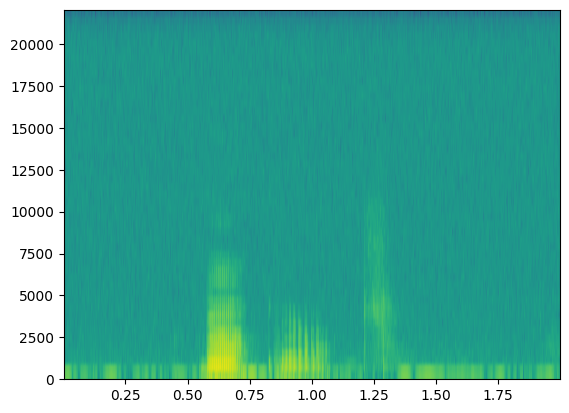

In [19]:
#create the objects for the training, validation and testing
obj_train = cDataLoader(train, batch_size=8, shuffle=True, data_path = data_path)
obj_validate = cDataLoader(val, batch_size=8, shuffle=True, data_path=data_path)
obj_test = cDataLoader(test, batch_size=8, shuffle=True, data_path = data_path)
print(obj_train[0][0].shape)
print(obj_validate.data[15])

(8, 370, 496, 3)
(None, 3)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_input (InputLayer)     [(None, 370, 496, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 368, 494, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 184, 247, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 182, 245, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 91, 122, 32)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (No

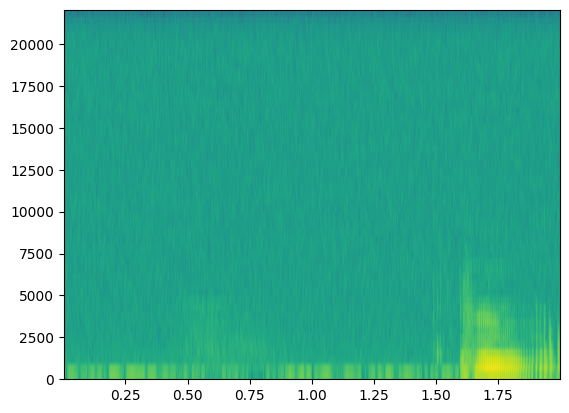

In [24]:
#model

b_size = 8
epochs = 10
sample_size = obj_data[1][0].shape
print(sample_size)

data_in = k.Input(shape=(sample_size[1], sample_size[2], sample_size[3]), name="data_input")

val = k.layers.Conv2D(filters=16, kernel_size=(3, 3), activation="relu")(data_in)
val = k.layers.MaxPooling2D(pool_size=(2, 2))(val)

val = k.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(val)
val = k.layers.MaxPooling2D(pool_size=(2, 2))(val)

val = k.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(val)
val = k.layers.MaxPooling2D(pool_size=(2, 2))(val)

val = k.layers.Flatten()(val)

val = k.layers.Dense(128, activation="relu", kernel_regularizer=l2(0.01))(val)
val = Dropout(0.5)(val)

val = k.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.01))(val)
val = Dropout(0.5)(val)

out = k.layers.Dense(3, name="out", activation="softmax")(val)

print(out.shape)

model = k.Model(inputs=data_in, outputs=[out])

model.compile(optimizer=k.optimizers.Adam(), loss=k.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()
hist = model.fit(obj_train, epochs=epochs, validation_data=obj_test)

Now using the code above, record some more samples for testing (10 for each category)
Save them in another file, I did in live_meta.txt

In [81]:
data_path = ".\\sound\\live\\"
live_meta_data_file = data_path + 'live.txt'
live_data = data_loader(live_meta_data_file)
#np.random.shuffle(live_data)
print(live_data[29])


{'id': '7d074e977ed24812b4459cd2eeedf46c', 'sampling_rate': 44100, 'duration': 2, 'file_name': 'backwards_live_9_.npy', 'label': 'backwards'}


Next we will create an object for the live data that we'll use for testing and let the model predict the categories.
label_dict={'gb': 0, 'forward':1, 'backwards':2} this is the dictionary

(4, 370, 496, 3)
8/8 [==============================] - 2s 209ms/step
[0 0 0 0 0 2 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 2 2 0 2 2 2 2 0 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]


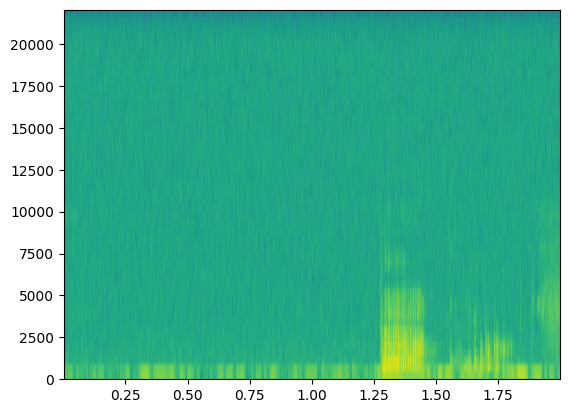

In [82]:
obj_live = cDataLoader(live_data, batch_size=4, shuffle=True, data_path = data_path)
print(obj_live[0][0].shape)
y_true = obj_live.get_labels()
y_true = np.array(y_true)
y_live_pred = model.predict(obj_live)
y_live_pred = np.argmax(y_live_pred, axis = 1)
print(y_live_pred)
print(y_true)

#  y_true is an array with the true labels of the recordings
#  y_live_pred is an array with the predictions


f1: 0.7666666666666667
              precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       1.00      0.80      0.89        10
           2       0.86      0.60      0.71        10

    accuracy                           0.77        30
   macro avg       0.82      0.77      0.77        30
weighted avg       0.82      0.77      0.77        30



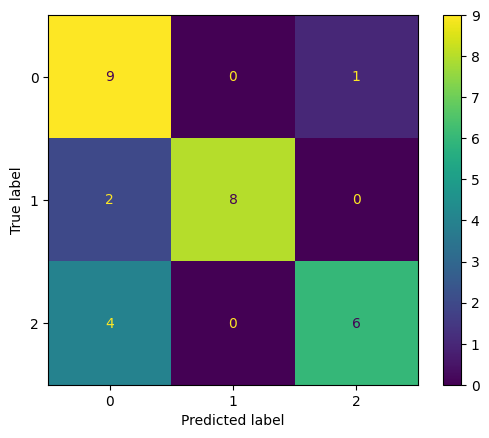

In [83]:
cfm = metrics.confusion_matrix(y_true, y_live_pred)
cfm_graph = ConfusionMatrixDisplay(cfm)
cfm_graph.plot()


print("f1:", metrics.f1_score(y_true, y_live_pred, average='micro'))
print(classification_report(y_true, y_live_pred))